## Problem Definition:

Malaria is a desease that infects healthy cells and kill them. It is transimted by female Anopheles mosquitoes when humans gets bitten by these insects.

After being infected the parasites enters the blood and attacks red cells (oxygen carriers in human's circulatory system
) which can result in respiratory distress and other complications.

Infected humans can show no symptoms and late treatment can evolve with complications and even be lethal.

More than 50% of the world is exposed to Malaria. In 2019 were there 229 millions Malaria cases and 400,000 related deaths to this desease. Children are the ones most at risk accounted 67% of worlwide's malaria deseases.

We need to solve the question about if it is possible to develope a deep learning model that is gonna be able to detect malario with a significant accuracy.

The final objective is to develope that model that can categorize uninfected and parasitized red cells accurate.

## Data set:

Data set contains labeled images of parasitized and uninfected red cells splitted into train and test.

## Loading needed libraries

In [2]:
# General data science libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

from concurrent.futures import ThreadPoolExecutor, as_completed

import random

# Image processing

import cv2
import os

# TensorFlow + Keras for deep learning

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, LeakyReLU, MaxPool2D
from keras.optimizers import Adam, SGD

from keras.utils import to_categorical

from keras.callbacks import EarlyStopping

# Data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pre-trained models

from tensorflow.keras.applications import VGG16

# Load model to re-train models saved

from keras.models import load_model

In [1]:
import warnings

# Filter out all warnings
warnings.filterwarnings('ignore')

#### Directories

In [2]:
# Train and test folders directories
test_dir = "cell_images/test"
train_dir = "cell_images/train"

## Count the number of images (test, train, parasitized and uninfected)

In [3]:
def count_images_in_directory(dir):
    
    return len([file for file in os.listdir(dir) if os.path.isfile(os.path.join(dir, file))])

In [4]:
print("Train set:\n ")

parasitized_train_count = count_images_in_directory(os.path.join(train_dir, "parasitized"))
print(f"Number of parasitized images in the training set: {parasitized_train_count}")

uninfected_train_count = count_images_in_directory(os.path.join(train_dir, "uninfected"))
print(f"Number of uninfected images in the training set: {uninfected_train_count}")

train_count = parasitized_train_count + uninfected_train_count
print(f"Total number of images in the training set: {train_count}")

print("\nTest set:\n ")

parasitized_test_count = count_images_in_directory(os.path.join(test_dir, "parasitized"))
print(f"Number of parasitized images in the test set: {parasitized_test_count}")

uninfected_test_count = count_images_in_directory(os.path.join(test_dir, "uninfected"))
print(f"Number of uninfected images in the test set: {uninfected_test_count}")

test_count = parasitized_test_count + uninfected_test_count
print(f"Total number of images in the test set: {test_count}")

Train set:
 
Number of parasitized images in the training set: 12582
Number of uninfected images in the training set: 12376
Total number of images in the training set: 24958

Test set:
 
Number of parasitized images in the test set: 1300
Number of uninfected images in the test set: 1300
Total number of images in the test set: 2600


## Load the data from

In [5]:
# Process the image to be used

def process_image(img_path, label,  size):


  img = cv2.imread(img_path)
  img = cv2.resize(img, (size, size))

  if img is not None:

    return img, label
    
  else:

    return None, None

process_image function does the first image processing resizing the image to use it as a viable input for our CNN.

Normilizing will be done after to start checking the image structre (min, max value for pixels, image shape, etc.) and format transformation.

## Function that loads the data spliting in X and y (image and label)

In [6]:
# This is gonna handle the loading of the data given the directories of train and test labeling the images according to the directory is holding it (1 for parasitized or 0 for uninfected)

def load_images_from_directory(dir, train_test):

  images = []
  labels = []

  for label in ['parasitized', 'uninfected']:

    count = 0

    path = os.path.join(dir, label)

    for image in os.listdir(path):

      img_path = os.path.join(path, image)

      img, img_label = process_image(img_path, label, 64) # Process the image to be used

      if img is not None and img_label is not None:

        images.append(img)
        labels.append(img_label)

      print(f"Loading {label} {train_test} images: {count}/{count_images_in_directory(path)}", end="\r")

      count += 1

    print()

  return images, labels

In [7]:
# Loading images with multi threading to speed up the proccess.

def load_images_from_directory_with_multithreading(dir):
    
    images = []
    labels = []

    tasks = []

    with ThreadPoolExecutor() as executor:

        for label in ['parasitized', 'uninfected']:

            path = os.path.join(dir, label)

            for image in os.listdir(path):

                img_path = os.path.join(path, image)

                tasks.append(executor.submit(process_image, img_path, label, 64))

        for task in as_completed(tasks):

            img, img_label = task.result()

            if img is not None and img_label is not None:

                images.append(img)
                labels.append(img_label)
        
    return np.array(images), np.array(labels)

#### Loading the data using multi threading to speed up the process, because it was taking too long.

In [8]:
X_train, y_train = load_images_from_directory_with_multithreading(train_dir)
X_test, y_test = load_images_from_directory_with_multithreading(test_dir)

#### As images are splited and sorted by category we will need to shuffle the data saving the correlation between image and category. Shuffle sklearn function will do this for us.

In [9]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

## Checking the shape of our data

In [10]:
print(f"X_train shape: {X_train.shape}")

print(f"y_train shape: {len(y_train)}")

X_train shape: (24958, 64, 64, 3)
y_train shape: 24958


#### Observations:

- We can see that our X_train has 24958 images with the shape we've given to it and 3 color channels.
- As we have seen on the count we have all the files on the data directories loaded.

## Check the min and max value for all the pixels in our train data

In [11]:
# Using min and max numpy fucntion to know the pixel values of the images and use this to normalize the data after

train_min, train_max = np.min(X_train), np.max(X_train) 
test_min, test_max = np.min(X_test), np.max(X_test)

print(f"Train images - Min pixel value: {train_min}, Max pixel value: {train_max}")
print(f"Test images - Min pixel value: {test_min}, Max pixel value: {test_max}")

Train images - Min pixel value: 0, Max pixel value: 255
Test images - Min pixel value: 0, Max pixel value: 255


#### Observations:

- Pixels min and max are the usuals with 256 aviable values (0 to 255)

#### First Image before normalization

In [12]:
print(f"First training data image shape: {X_train[0].shape}")
print(f"First training data image label: {y_train[0]}")

print(f"First testing data image min and max: {np.min(X_test[0]), np.max(X_test[0])}")
print(f"First testing data image label: {y_test[0]}")


First training data image shape: (64, 64, 3)
First training data image label: uninfected
First testing data image min and max: (np.uint8(0), np.uint8(209))
First testing data image label: uninfected


In [13]:
# One hot encoding the labels

# Convert 'parasitized' to 1 and 'uninfected' to 0
y_train = np.where(y_train == 'parasitized', 1, 0)
y_test = np.where(y_test == 'parasitized', 1, 0)

# One hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [14]:
print(f"First training data image shape: {X_train[0].shape}")

print(f"First training data image label: {y_train[0]}")

print(f"First testing data image min and max: {np.min(X_test[0]), np.max(X_test[0])}")

First training data image shape: (64, 64, 3)
First training data image label: [1. 0.]
First testing data image min and max: (np.uint8(0), np.uint8(209))


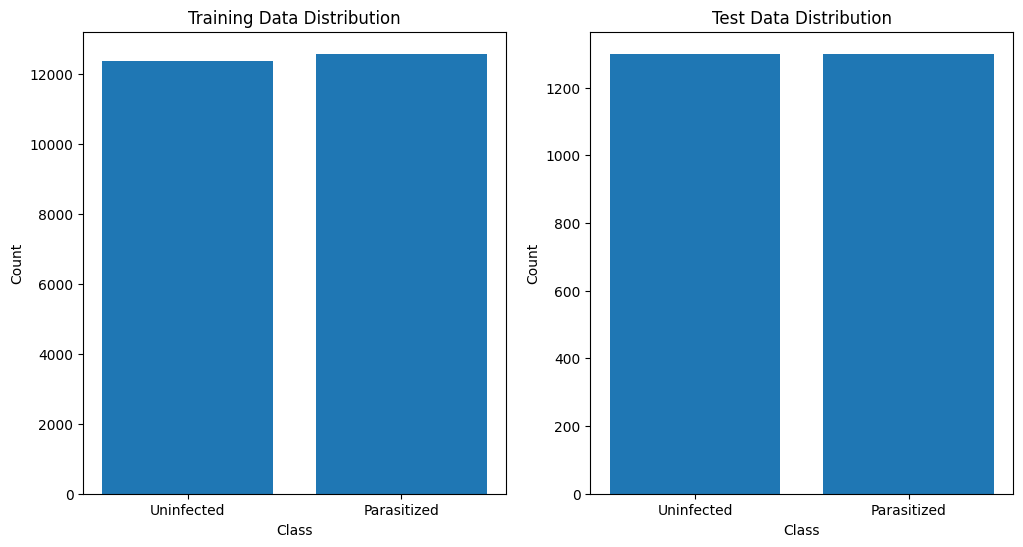

In [15]:
# Count the number of each class in the training and test datasets
train_class_counts = np.sum(y_train, axis=0)
test_class_counts = np.sum(y_test, axis=0)

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(['Uninfected', 'Parasitized'], train_class_counts)
ax[0].set_title('Training Data Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

ax[1].bar(['Uninfected', 'Parasitized'], test_class_counts)
ax[1].set_title('Test Data Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.show()

#### Observations:

- The data is balanced. It will contribute to have a better result, because unbalanced data are not the best to get inferences out of it.

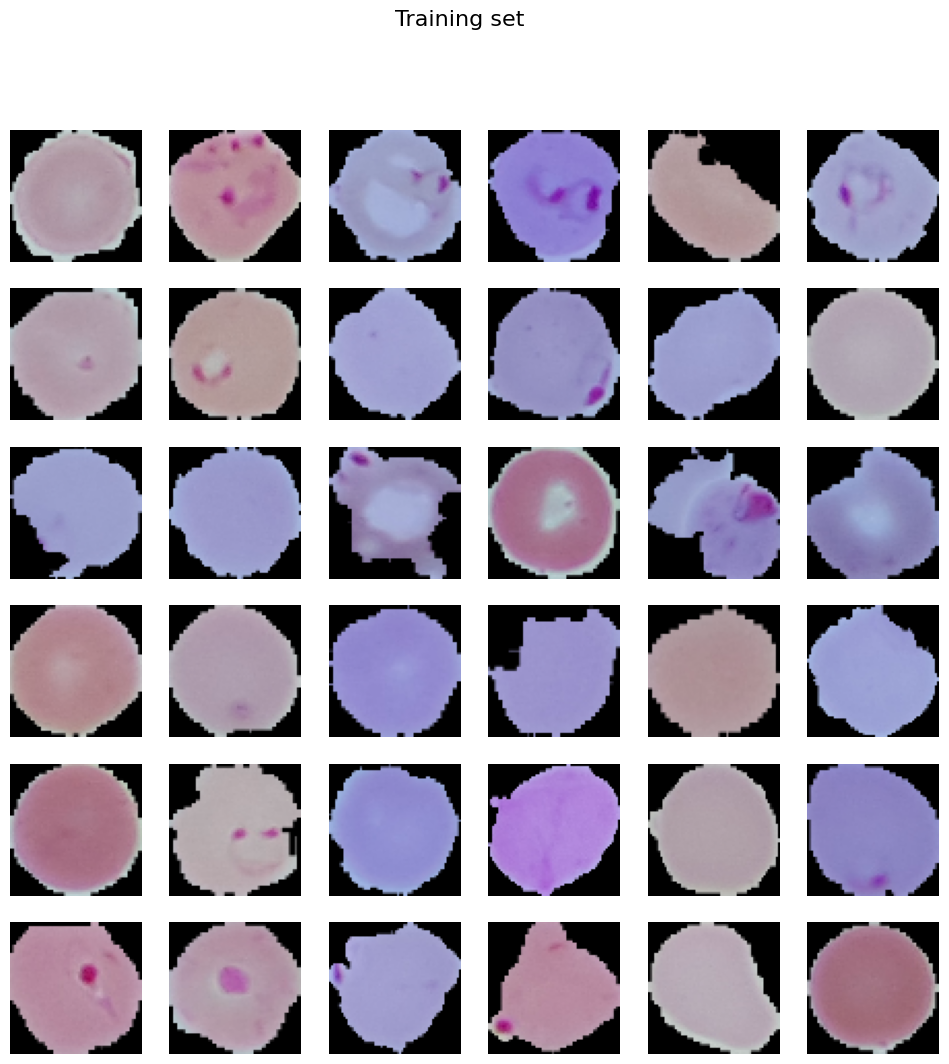

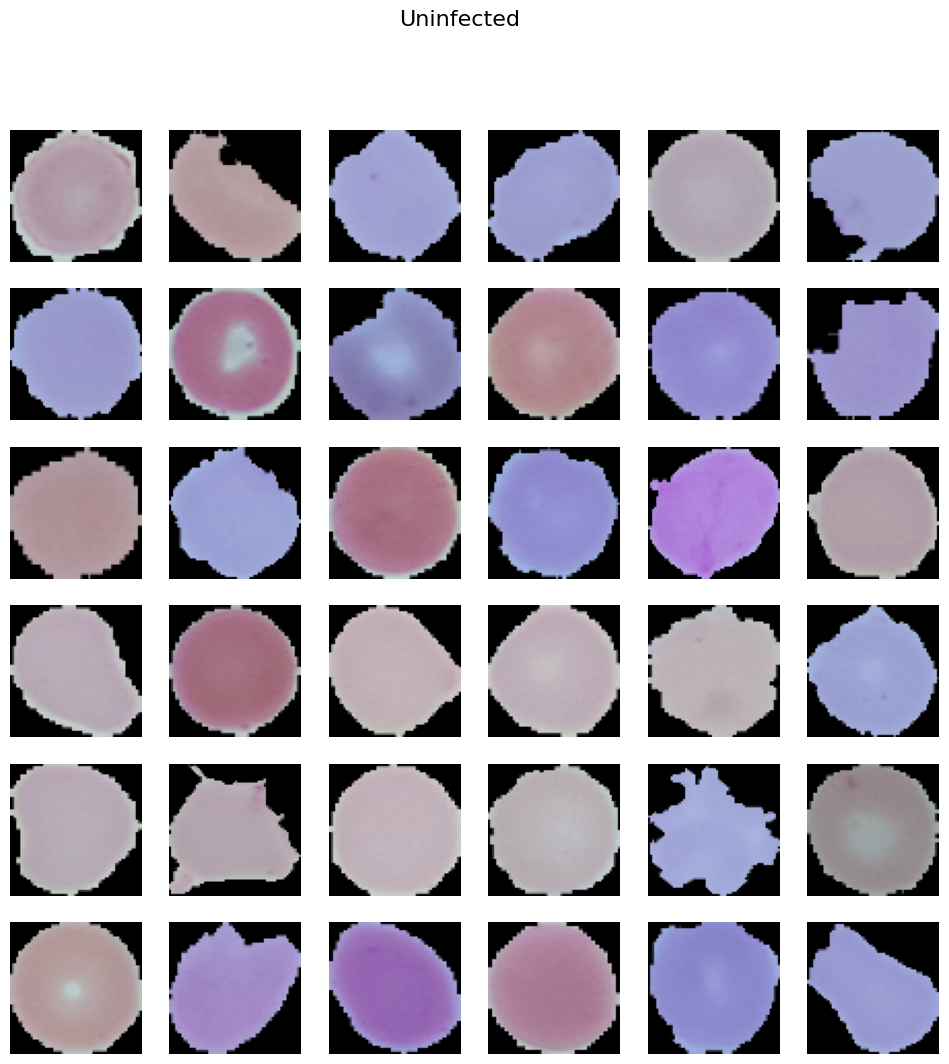

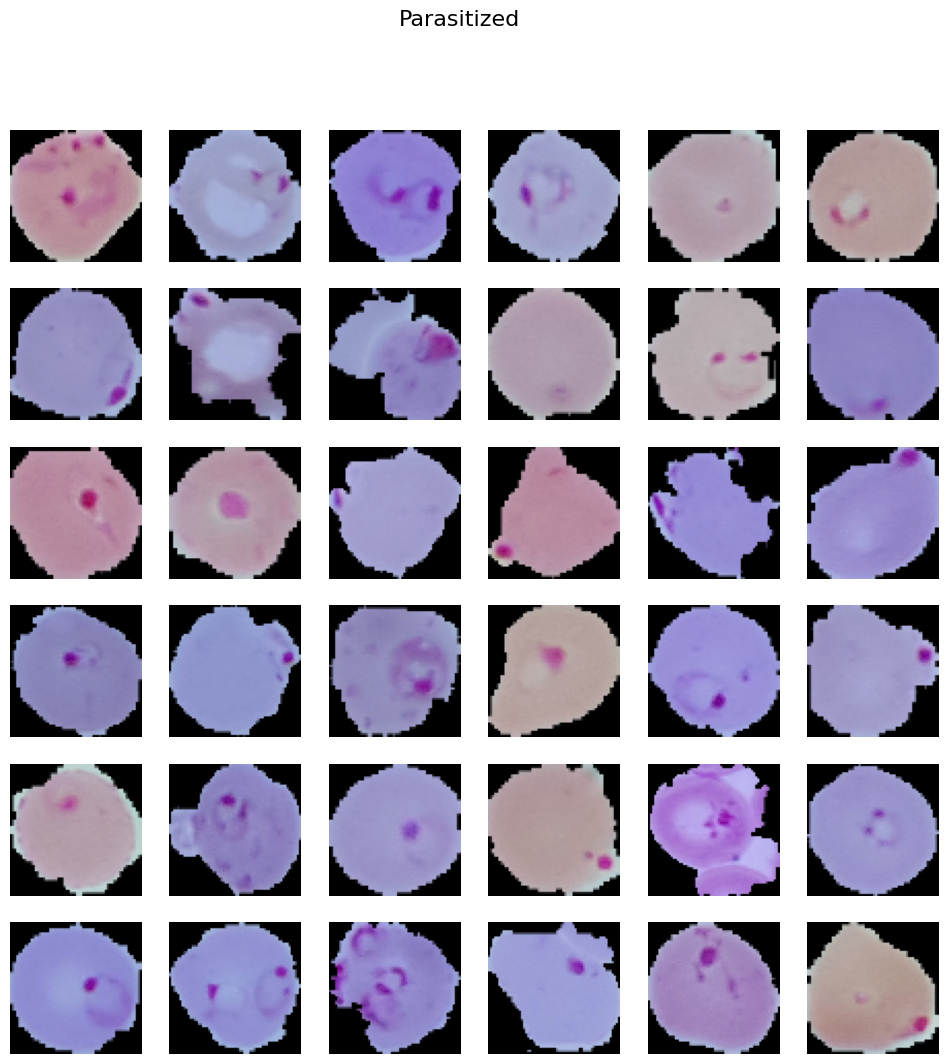

In [16]:
# Visualize the first 36 images from the training data
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.suptitle('Training set', fontsize=16)

for i, ax in enumerate(axes.flat[:36]):
    ax.imshow(X_train[i])
    ax.axis('off')

    # Find the indices of the uninfected images
    uninfected_indices = np.where(np.argmax(y_train, axis=1) == 0)[0]
    parasitized_indices = np.where(np.argmax(y_train, axis=1) == 1)[0]

# Visualize the first 36 uninfected images
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.suptitle('Uninfected', fontsize=16)

for i, ax in enumerate(axes.flat[:36]):
    ax.imshow(X_train[uninfected_indices[i]])
    ax.axis('off')

# Visualize the first 36 parasitized images
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.suptitle('Parasitized', fontsize=16)

for i, ax in enumerate(axes.flat[:36]):
    ax.imshow(X_train[parasitized_indices[i]])
    ax.axis('off')

plt.show()

## Observations:</b>

We can see how infected cells are clearly damaged by malaria, but now we need the model to recognize it.

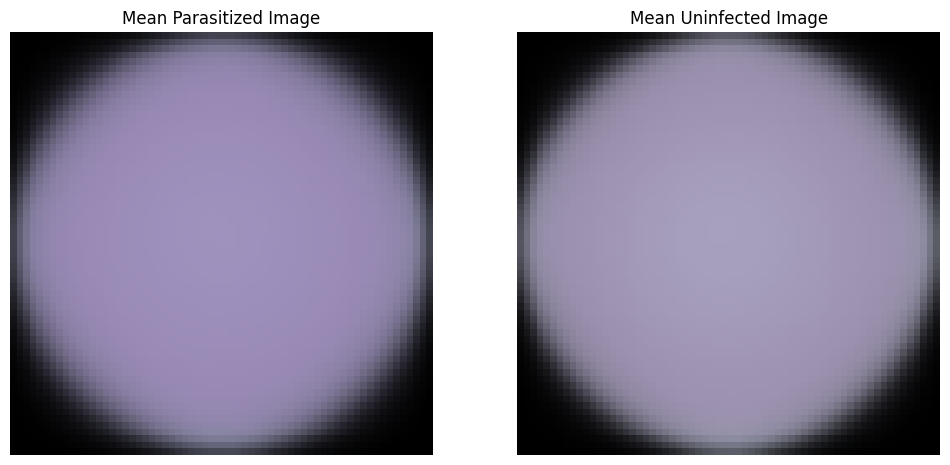

In [17]:
# Calculate the mean image for parasitized and uninfected classes
mean_parasitized = np.mean(X_train[np.argmax(y_train, axis=1) == 1], axis=0)/255.0
mean_uninfected = np.mean(X_train[np.argmax(y_train, axis=1) == 0], axis=0)/255.0

# Plot the mean images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(mean_parasitized)
axes[0].set_title('Mean Parasitized Image')
axes[0].axis('off')

axes[1].imshow(mean_uninfected)
axes[1].set_title('Mean Uninfected Image')
axes[1].axis('off')

plt.show()

## Converting Images to HSV

In [18]:
# Convert RGB images to HSV
X_train_hsv = np.array([cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_RGB2HSV) for img in X_train])
X_test_hsv = np.array([cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_RGB2HSV) for img in X_test])

print(f"First training data image shape (HSV): {X_train_hsv[0].shape}")
print(f"First testing data image shape (HSV): {X_test_hsv[0].shape}")

print(f"First training data image min and max (HSV): {np.min(X_train_hsv[0]), np.max(X_train_hsv[0])}")

First training data image shape (HSV): (64, 64, 3)
First testing data image shape (HSV): (64, 64, 3)
First training data image min and max (HSV): (np.uint8(0), np.uint8(210))


#### Observations:

I had to "de-normalize" the images to convert to HSV

## Processing Images using Gaussian Blurring

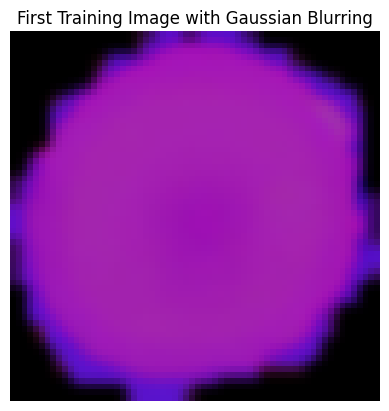

In [19]:
# Apply Gaussian Blurring to the images
def apply_gaussian_blur(images, kernel_size=(5, 5), sigma=0):
    blurred_images = np.array([cv2.GaussianBlur(img, kernel_size, sigma) for img in images])
    return blurred_images

# Apply Gaussian Blurring to the training and test datasets
X_train_blurred = apply_gaussian_blur(X_train_hsv)
X_test_blurred = apply_gaussian_blur(X_test_hsv)

# Display the first blurred image from the training set
plt.imshow(X_train_blurred[0])
plt.title('First Training Image with Gaussian Blurring')
plt.axis('off')
plt.show()

#### Normilize HSV

In [20]:
X_train_blurred = X_train_blurred / 255.0

In [21]:
X_test_blurred = X_test_blurred / 255.0

## Observations about the data exploration:

- Data contains 24,958 training labeled images well balanced between parasitized and uninfected red cells.
- Test data has 2,600 images (1300 for each category).
- Data was sorted by category so it needed to be shuffled to the models not overfit on the first category data given to it.
- At sight parasitized red cells have red spots where the parasite is attacking each cell.
- Images got transformed into HSV format 
- HSV format would helps in better distinguishing the color variations caused by the parasite in the red cells.
- Gaussian blur will help reducing the images noise and detail helping the model to focus on the important features.


## Start creating our CNN model

In [22]:
def CNN_model_1():

    model = Sequential()

    model.add(Input(shape=(64,64,3)))

    # Convolutional layers

    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())

    # Flatten layer to feed the data to the dense layers

    model.add(Flatten())

    # Fully connected layers

    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model  


In [23]:
cnn_model_1 = CNN_model_1()
cnn_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,138 (1.11 MB)

 Trainable params: 291,042 (1.11 MB)

 Non-trainable params: 96 (384.00 B)

#### Let's fit the model

In [24]:
cnn_model_1_history = cnn_model_1.fit(X_train_blurred, y_train, validation_split=0.2, batch_size=256, verbose=1, epochs=20)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy: 0.5308 - loss: 0.8130 - val_accuracy: 0.5056 - val_loss: 0.7487
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 402ms/step - accuracy: 0.6950 - loss: 0.5542 - val_accuracy: 0.5056 - val_loss: 4.4545
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 393ms/step - accuracy: 0.9444 - loss: 0.1923 - val_accuracy: 0.5062 - val_loss: 4.4096
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 381ms/step - accuracy: 0.9631 - loss: 0.1315 - val_accuracy: 0.5887 - val_loss: 2.0972
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 361ms/step - accuracy: 0.9719 - loss: 0.0951 - val_accuracy: 0.7346 - val_loss: 1.3270
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 361ms/step - accuracy: 0.9738 - loss: 0.0838 - val_accuracy: 0.9243 - val_loss: 0.3280
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 352ms/step - accuracy: 0.9736 - loss: 0.0943 - val_accuracy: 0.9509 - val_loss: 0.1980
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 352ms/step - accuracy: 0.9785 - loss: 0.0738 - val_accu

#### Take a look out of our training results

In [25]:
def model_plot(history, metric:str = 'accuracy'):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'lower right')
    plt.show()

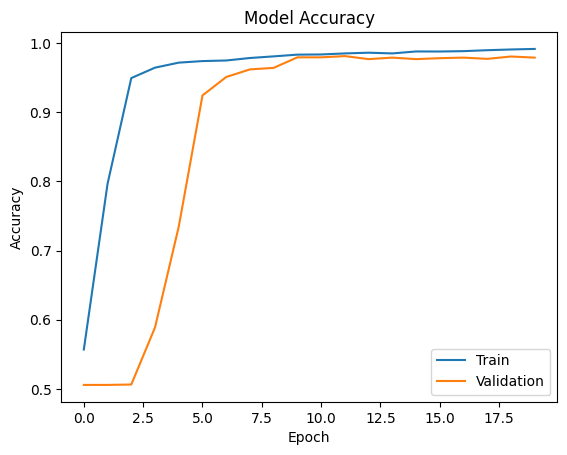

In [26]:
model_plot(cnn_model_1_history)

In [27]:
model_1_pred= cnn_model_1.predict(X_test_blurred)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [28]:
def plot_predictions(model_pred, y_test, class_names):

    # Convert predictions to class labels
    y_pred_classes = np.argmax(model_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
        
    # Print the classification report
    print(classification_report(y_test_classes, y_pred_classes))

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Annotate the heatmap with class labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.gca().xaxis.set_tick_params(rotation=0)
    plt.gca().yaxis.set_tick_params(rotation=0)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



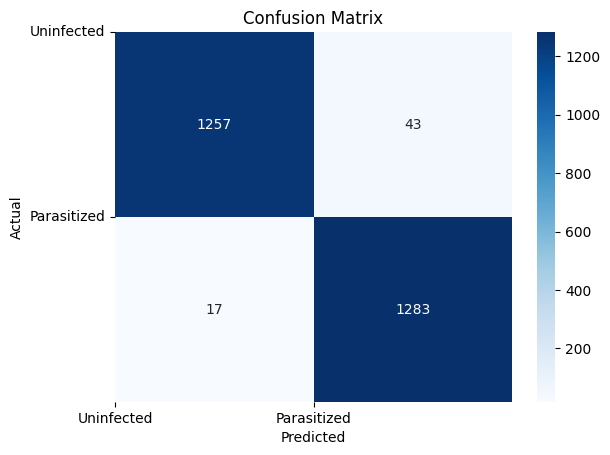

In [29]:
plot_predictions(model_1_pred, y_test, ['Uninfected', 'Parasitized'])

#### Observarion:

- We can see that this model is doing well reaching his best performance at 10 epochs aproximate, then just staying at that point. So with this model we're not going over 98% accuracy on training as we see.
- The model is performing better on test data (new data) than on the training itself.
- Doesn't look like the model is overfitting or underfittin, what is pretty good going forward.

## This model did pretty well. I will save it to use it after and do not lose the training with the backend clearing.

In [30]:
cnn_model_1.save('cnn_model_1.h5')

## I will clear backend and restart seeds.

In [3]:
def clear_backend_restart_seeds():
    # Clear Keras backend

    keras.backend.clear_session()

    # Fix the seed for random number generators

    np.random.seed(42)

    random.seed(42)

    tf.random.set_seed(42)

In [4]:
clear_backend_restart_seeds()

In [33]:
def CNN_model_2():

    model = Sequential()

    model.add(Input(shape=(64,64,3)))

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))


    model.add(Flatten())

    model.add(Dense(128))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model  

In [34]:
cnn_model_2 = CNN_model_2()
cnn_model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,706 (16.36 MB)

 Trainable params: 4,288,322 (16.36 MB)

 Non-trainable params: 384 (1.50 KB)

In [35]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
cnn_model_2_history = cnn_model_2.fit(X_train_blurred, y_train, validation_split=0.2, batch_size=64, verbose=1, epochs=10, callbacks=[early_stopping])

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 136s 423ms/step - accuracy: 0.6158 - loss: 3.1581 - val_accuracy: 0.5072 - val_loss: 14.9922
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 132s 423ms/step - accuracy: 0.9245 - loss: 0.2715 - val_accuracy: 0.9397 - val_loss: 0.2054
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 129s 415ms/step - accuracy: 0.9547 - loss: 0.1679 - val_accuracy: 0.9708 - val_loss: 0.1069
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 131s 421ms/step - accuracy: 0.9683 - loss: 0.1228 - val_accuracy: 0.9643 - val_loss: 0.1484
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 131s 418ms/step - accuracy: 0.9716 - loss: 0.1059 - val_accuracy: 0.9659 - val_loss: 0.1123
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 130s 415ms/step - accuracy: 0.9749 - loss: 0.0898 - val_accuracy: 0.9681 - val_loss: 0.1120


#### Observations:
- EarlyStopping verbose wasn't on, that's why it is not showing any message of EarlyStopping stopping the training.
- I've trained this model several times and results weren't consistents from one to another training, that's why I'm not gonna consider this model as a final model. Sometimes it was jumping around (accuracy going up and down), because the model was overfitting the training data.
- These last results are good, but the previous model is doing better and this model wasn't consistent.

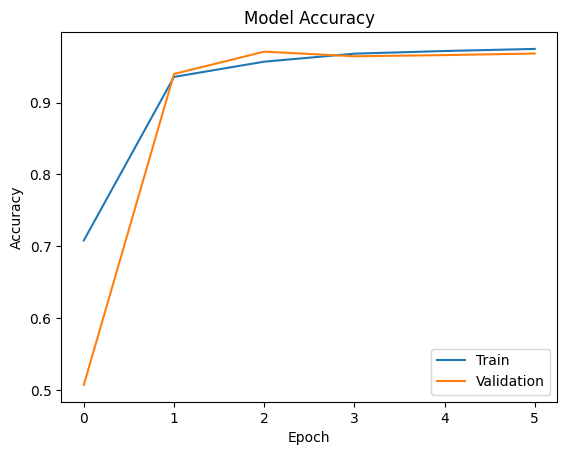

In [36]:
model_plot(cnn_model_2_history)

In [37]:
model_2_prediction = cnn_model_2.predict(X_test_blurred)

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



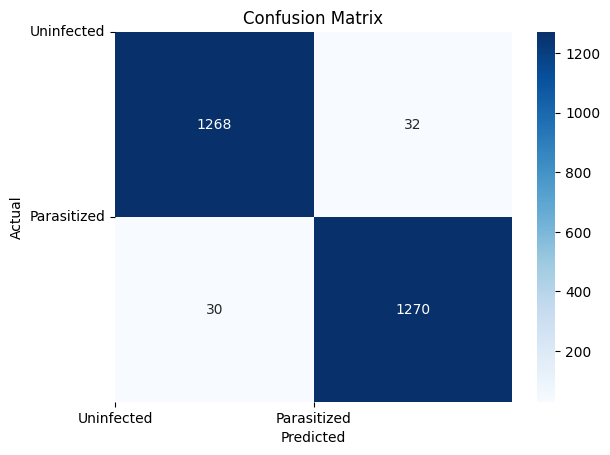

In [38]:
plot_predictions(model_2_prediction, y_test, ['Uninfected', 'Parasitized'])

#### Observations:

For some reason the model is actually doing well with the test data, but I could not be able to explain this behaviour.

I've explained above why this one is not gonna be considered as final prediction model.

## Clear backend and restart seeds

In [39]:
clear_backend_restart_seeds()

In [40]:
def CNN_model_3():
    
    model = Sequential()

    model.add(Input(shape=(64,64,3)))

    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(32))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [41]:
cnn_model_3 = CNN_model_3()
cnn_model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 937,506 (3.58 MB)

 Trainable params: 936,610 (3.57 MB)

 Non-trainable params: 896 (3.50 KB)

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
cnn_model_3_history = cnn_model_3.fit(X_train_blurred, y_train, validation_split=0.2, batch_size=64, verbose=1, epochs=20, callbacks=[early_stopping])

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 171s 529ms/step - accuracy: 0.4930 - loss: 0.9788 - val_accuracy: 0.5074 - val_loss: 0.6942
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 155s 498ms/step - accuracy: 0.5032 - loss: 0.7087 - val_accuracy: 0.4980 - val_loss: 0.6933
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 166s 532ms/step - accuracy: 0.5067 - loss: 0.6998 - val_accuracy: 0.4944 - val_loss: 0.6939
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 168s 540ms/step - accuracy: 0.5546 - loss: 0.6845 - val_accuracy: 0.4944 - val_loss: 0.6912
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 165s 528ms/step - accuracy: 0.8129 - loss: 0.4457 - val_accuracy: 0.8976 - val_loss: 0.3635
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 166s 533ms/step - accuracy: 0.9614 - loss: 0.1355 - val_accuracy: 0.9605 - val_loss: 0.1122
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.9764 - loss: 0.0891 - val_accuracy: 0.9764 - val_loss: 0.0701
Epoch 8/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 172s 550ms/step - accuracy: 0.9764 -

#### Observations:

Model got stopped showing that improvement was already reaching his seiling.

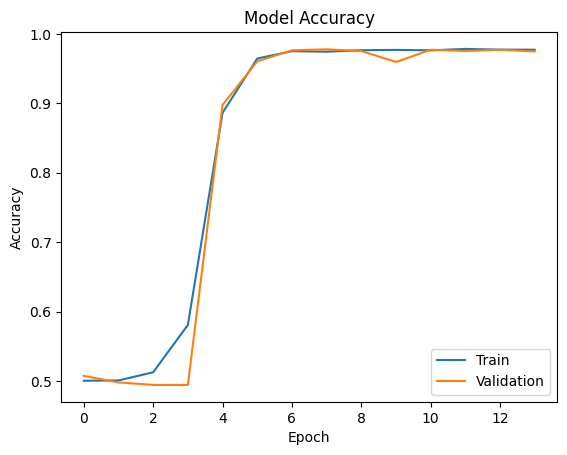

In [43]:
model_plot(cnn_model_3_history)

In [44]:
model_3_pred = cnn_model_3.predict(X_test_blurred)

82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



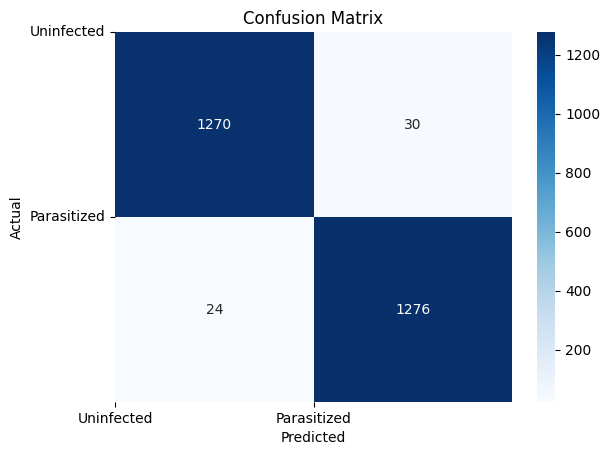

In [45]:
plot_predictions(model_3_pred, y_test, ['Uninfected', 'Parasitized'])

## observations:
- This model did actually pretty well. I'm gonna save it too if we can use it later.
- I wasn't expecting this model to do that well, my thoughts were that this model could overfit because of the complexity of the fully connected network.

In [46]:
cnn_model_1.save('cnn_model_3.h5')

## Let's try some image augmentation

## Clear backend and restart seeds

In [47]:
clear_backend_restart_seeds()

In [48]:
# Create an instance of the ImageDataGenerator class

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [49]:
# Fit the data generator on the training data

datagen.fit(X_train_blurred)

In [50]:
# Create a data generator for the training data

train_generator = datagen.flow(X_train_blurred, y_train)
print(f"Train data size after augmentation: {len(train_generator)}")

# Manually split the train_generator into train and validation

train_size = int(0.8 * len(train_generator))
print(f"Train data size after augmentation: {train_size}")
val_size = len(train_generator) - train_size

train_data = []
val_data = []

for i in range(len(train_generator)):
    if i < train_size:
        train_data.append(train_generator[i])
    else:
        val_data.append(train_generator[i])

train_data = np.concatenate([x[0] for x in train_data]), np.concatenate([x[1] for x in train_data])
val_data = np.concatenate([x[0] for x in val_data]), np.concatenate([x[1] for x in val_data])

Train data size after augmentation: 780
Train data size after augmentation: 624


#### Let's load the cnn_model_1 to train it now with the augmented data (this is gonna keep the previous training with the inicial training data)

In [5]:
# Load the model from the file
cnn_model_1 = load_model('cnn_model_1.h5')

# Display the model summary
cnn_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,140 (1.11 MB)

 Trainable params: 291,042 (1.11 MB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 2 (12.00 B)

In [55]:
# Recompile the model
cnn_model_1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the manually split augmented data
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.003, verbose=1 , patience=3, restore_best_weights=True)

cnn_model_1_history_augmented = cnn_model_1.fit(train_data[0], train_data[1], validation_data=val_data, batch_size=64, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 265ms/step - accuracy: 0.9344 - loss: 0.2205 - val_accuracy: 0.9541 - val_loss: 0.1538
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 78s 251ms/step - accuracy: 0.9539 - loss: 0.1453 - val_accuracy: 0.9485 - val_loss: 0.1597
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - accuracy: 0.9598 - loss: 0.1365 - val_accuracy: 0.9613 - val_loss: 0.1324
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 78s 251ms/step - accuracy: 0.9632 - loss: 0.1209 - val_accuracy: 0.9509 - val_loss: 0.1698
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - accuracy: 0.9648 - loss: 0.1185 - val_accuracy: 0.9523 - val_loss: 0.1606
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 78s 251ms/step - accuracy: 0.9670 - loss: 0.1042 - val_accuracy: 0.9589 - val_loss: 0.1457
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


#### Observations:

- Model got stopped before the 20 epochs, looking like the improve wasn't being much.

This was expected, because the size of the augmented data wasn't big, just 624 training images and continueing with the training could lead into overfitting.
- Augmented data will help the model to generalize on new data, showing the model partial images, rotated images or other features out the images.

In [ ]:
# Predict on the test data
cnn_model_1_history_augmented_pred = cnn_model_1.predict(X_test_blurred)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



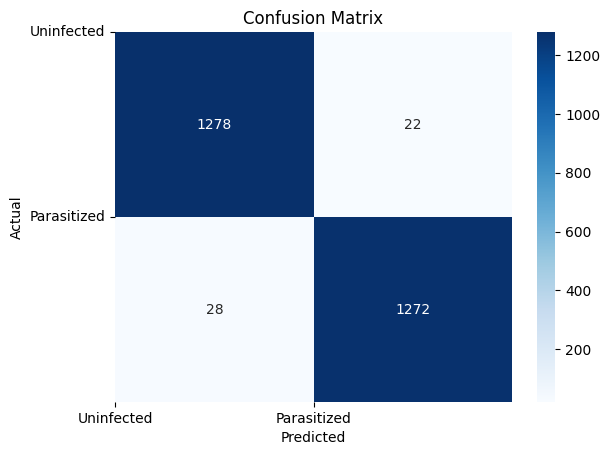

In [ ]:
plot_predictions(cnn_model_1_history_augmented_pred, y_test, ['Uninfected', 'Parasitized'])

#### Observations:

For now this is the best model, the one comiting less mistakes.

Is pretty consistent on both categories.

The extra training with the augmented data helped the model to miss on less predictions, so this is the model with the best performance for now.

In [56]:
cnn_model_1.save('cnn_model_1_after_augmentation.h5')

## Let's restart backend and seeds

In [57]:
clear_backend_restart_seeds()

#### I'm gonna try a model with the same fully connected structur but using the VGG16 for the convolutional part of the model.

In [61]:
def CNN_model_1_VGG16():

    model = Sequential()

    # Load the VGG16 model, excluding the top layers
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Add the VGG16 model to our Sequential model
    model.add(vgg16)

    # Flatten layer to feed the data to the dense layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model  

In [62]:
cnn_model_1_vgg16 = CNN_model_1_VGG16()
cnn_model_1_vgg16.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,862,530 (56.70 MB)

 Trainable params: 14,862,530 (56.70 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3, verbose=1, restore_best_weights=True)
cnn_model_1_VGG16_history = cnn_model_1_vgg16.fit(X_train_blurred, y_train, validation_split=0.2, batch_size=64, epochs=10, verbose=1, callbacks=early_stopping)

c:\Users\kheid\.virtualenvs\8.-_Cpastone_Project_-_Malaria_Detection-P-nFpC7m\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.4984 - loss: 0.7212 - val_accuracy: 0.4944 - val_loss: 0.6949
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.5051 - loss: 0.6970 - val_accuracy: 0.4944 - val_loss: 0.6934
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.4936 - loss: 0.6939 - val_accuracy: 0.4944 - val_loss: 0.6936
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.4958 - loss: 0.6945 - val_accuracy: 0.4944 - val_loss: 0.6936
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


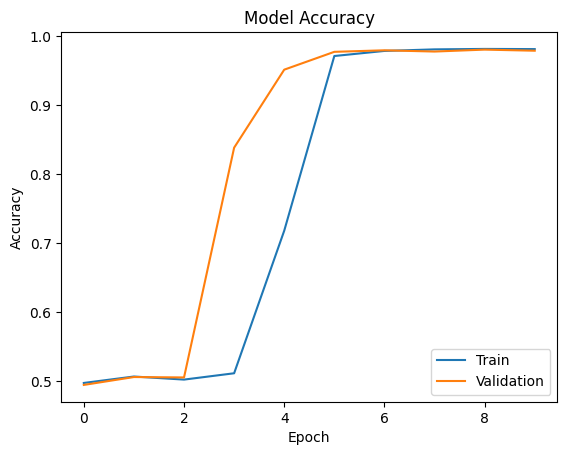

In [ ]:
model_plot(cnn_model_1_VGG16_history)

#### Observations:

The model was stopped by Early Stopping at epoch 4, that makes this last plot not a good way to measure the results, because it is, for some reason asuming the acuracy would reach over 90%.

I'm not pretty sure why is it happening, but the plot should be capped at ~50% validation accuracy.

In [ ]:
VGG16_pred = cnn_model_1_vgg16.predict(X_test_blurred)

82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step


              precision    recall  f1-score   support

           0       0.49      0.95      0.65      1300
           1       0.31      0.02      0.04      1300

    accuracy                           0.49      2600
   macro avg       0.40      0.49      0.35      2600
weighted avg       0.40      0.49      0.35      2600



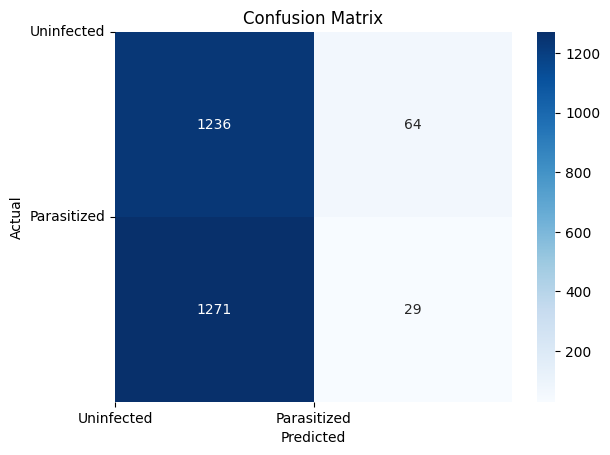

In [ ]:
plot_predictions(VGG16_pred, y_test, ['Uninfected', 'Parasitized'])

Confusion matrix shows us that VGG16 is not helping on the training having a poor performance not being able to catch any patron on the images just going all in for uninfected.

#### Observations:

- This model is underfitting and not doing any good neither on the training or test data.
- I've tried training the model several times, but the result was always the same with no huge variations on the accuracy.
- We can say this model is not good at all so the decision of which model to use is gonna be between model 1 with data augmentation or the model 3 with a more complex fully connected network.

## Conclusions:

- We were able to train an efficient model that can distinguish between healthy red cells and parasitized red cells. Actually two models are in shape to do this job reaching high accuracy after training epochs.
- Data augmentation helped improving a pre-trained model to improve his permormanc on new data.
- EarlyStopping helped saving time and avoiding some models to reach a point of overfitting.
- The VGG16 didn't show any good results on this data set, was actually the model with the worst performance out of all four models.
- The difference between cnn_model_1, cnn_model_2 and cnn_model_3 was the complexity of each, being 3 the most complex and 2 the most simple model where model 2 was overfitting on some training rounds and model 3 not doing much better than model 1 besides being much more complex, leading into longer training times what is not compensated with the results not being better.

#### Selected Model: cnn_model_1 after secondary training with augmented data.

- The bests results were with the cnn_model_1 after giving to it a secondary training using data augmentation techniques to improve the way the model generalize on new data.
- The model has missed just 50 predictions, somethings that's really good reaching 98% accuracy and 98% recall shown on the confusion matrix.
- This model is not too complex or too simple leading into a model fitting well on all the data given (during training with training and validation data and with the test data doing accurate predictions).

#### Future Work:

- Experiment with different architectures and hyperparameters to find the optimal model.
- Investigate the use of transfer learning with other pre-trained models.
- Deploy the model in a real-world application to assist in the diagnosis of malaria.
- Get more labeled data to train the model with a bigger data set.